# Install and import relevant libraries

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math

# Read and load the data

In [181]:
def load_data(data):
  return pd.read_csv(data)

def variable_data(data):
  y = data.values[:,0].astype('float')
  x = data.values[:,1:].astype('float')
  column = list(data.columns.values.tolist())
  feature_name = [str(x) for x in column[1:]]
  return y, x, feature_name

Data source: https://nirpyresearch.com/principal-component-regression-python/

In [182]:
dataset = 'dataset/peach_spectra_brix.csv'
dataset = pd.read_csv(dataset)
dataset.head()

# Extract data variables
y, x, wavelength = variable_data(dataset) 

n_samples, n_features = x.shape
print('Number of samples:', n_samples)
print('Number of features:', n_features)

dataset.describe().transpose()


Number of samples: 50
Number of features: 600


,count,mean,std,min,25%,50%,75%,max
Brix,50.0,16.436000,2.180504,11.200000,15.150000,16.750000,18.100000,20.000000
1100,50.0,-1.048735,0.082238,-1.214996,-1.117203,-1.052955,-0.995029,-0.833572
1102,50.0,-1.046894,0.082218,-1.213145,-1.115397,-1.051157,-0.993171,-0.831776
1104,50.0,-1.044262,0.082173,-1.210363,-1.112815,-1.048572,-0.990520,-0.829267
1106,50.0,-1.041133,0.082099,-1.206912,-1.109705,-1.045503,-0.987393,-0.826347
...,...,...,...,...,...,...,...,...
2290,50.0,0.700483,0.022280,0.649538,0.685930,0.700594,0.714617,0.773737
2292,50.0,0.693967,0.021535,0.645104,0.679964,0.694490,0.707072,0.765342
2294,50.0,0.686261,0.020698,0.639860,0.673203,0.687160,0.698290,0.755395
2296,50.0,0.677345,0.019780,0.633757,0.665492,0.678200,0.688299,0.743916


## Plot spectra

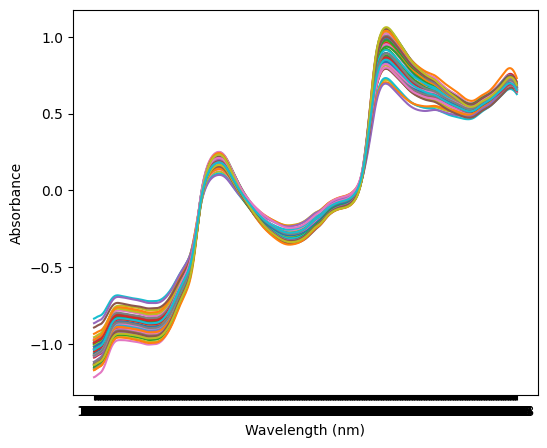

In [183]:
def plot_spectra(x, y):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot()
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    plt.plot(x, y.T)
    plt.xticks()
    plt.ylabel('Absorbance')
    plt.xlabel('Wavelength (nm)')
    plt.grid(False) # visible=None, which='major', axis='both', **kwargs
    plt.show()
plot_spectra(wavelength, x)

## Spectral Preprocessing

In [184]:
from scipy.signal import savgol_filter
"""SIMPLE MOVING AVERAGE"""
def sma(input_spectra, window_size):
    df = pd.DataFrame(input_spectra)
    moving_averages = df.rolling(window_size, min_periods=1).mean()#.iloc[window_size-1:].values
    return moving_averages

"""MULTIPLICATIVE SCATTER CORRECTION"""
def msc(input_spectra, reference=None):
    # --- Mean center correction
    for i in range(input_spectra.shape[0]):
        input_spectra[i,:] -= input_spectra[i,:].mean()
    # --- Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # --- Calculate mean
        ref = np.mean(input_spectra, axis=0)
    else:
        ref = reference
    # --- Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Run regression
        fit = np.polyfit(ref, input_spectra[i,:], 1, full=True)
        # --- Apply correction
        data_msc[i,:] = (input_spectra[i,:] - fit[0][1]) / fit[0][0]
    return data_msc, ref

"""STANDARD NORMAL VARIATE"""
def snv(input_spectra):
    # --- Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Apply correction
        output_data[i,:] = (input_spectra[i,:] - np.mean(input_spectra[i,:])) / np.std(input_spectra[i,:])
    return output_data

"""SAVITZKY-GOLAY SMOOTHING"""
def SG_smoothing(input_data, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    return SG_smoothing

"""SAVITZKY-GOLAY DERIVATIVE"""
def SG_derivative(input_data, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    return SG_filter

## Data scaling

In [185]:
from sklearn.preprocessing import StandardScaler
"""STEP 1 - Data Scaling"""
x_scaled = StandardScaler().fit_transform(x)

# Principal Component Analysis

In [186]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
n_comps = 10
pca = PCA()
x_std = StandardScaler().fit_transform(x[:,:])
x_pca = pca.fit_transform(x_std)[:,:n_comps]


Sorted Eignevalues: 489.149
Sorted Eignevalues: 89.17
Sorted Eignevalues: 20.754
Sorted Eignevalues: 7.974
Sorted Eignevalues: 2.822
Sorted Eignevalues: 1.06
Explained Variance: 79.89%
Explained Variance: 14.56%
Explained Variance: 3.39%
Explained Variance: 1.3%
Explained Variance: 0.46%
Explained Variance: 0.17%


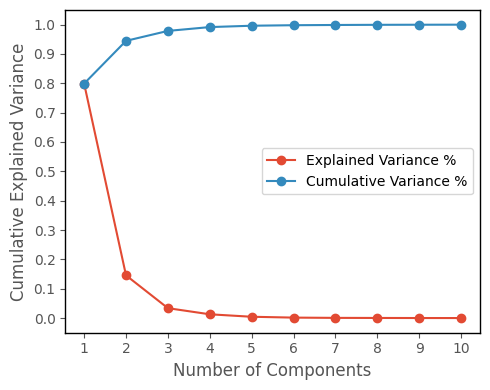

In [187]:
def principalcomponentanalysis(num_comps, x):    
    pca = PCA(n_components=num_comps)
    """Fit the spectral data and extract the explained variance ratio"""
    X = pca.fit(x)
    """Explained variances equal to n_components largest eigenvalues of the covariance matrix of X."""
    var_expl = X.explained_variance_
    for a in var_expl:
        if(a>0.5):
            print('Sorted Eignevalues: {}'.format(round(a, 3)))
    """Percentage of variance explained by each of the selected components."""
    var_expl_ratio = X.explained_variance_ratio_
    for b in var_expl_ratio:
        if (b>(0.1/100)):
            print('Explained Variance: {}%'.format(round(b*100, 2)))
    """Scree Plot"""
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(5,4))
        fig.set_tight_layout(True)
        ax.plot(np.arange(1, num_comps+1), var_expl_ratio, '-o', label='Explained Variance %')
        ax.plot(np.arange(1, num_comps+1), np.cumsum(var_expl_ratio), '-o', label = 'Cumulative Variance %')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.set_xlabel('Number of Components')
        ax.set_yticks(np.arange(0.0, 1.1, step=0.1))
        ax.set_xticks(np.arange(1, num_comps+1, step=1))
        ax.spines['left'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.set_facecolor("white")
    plt.legend()
    plt.show()

    """Get Principle Components (PCs) or PCA scores"""
    # Transform on the scaled features
    x_comps = pca.fit_transform(x)
    
    return (x_comps)
x_comps = principalcomponentanalysis(n_comps, x_scaled)

In [188]:
pc_list = ['PC'+ str(i) for i in list(range(1, n_comps+1))]

"""PCA Loading or correlation coefficients"""
df_xcomps = pd.DataFrame.from_dict(dict(zip(pc_list, x_comps)))
print('Projected X data\n',df_xcomps.head())

Projected X data
          PC1        PC2        PC3        PC4        PC5        PC6  \
0  10.939714   9.704661  26.292404  21.012176  11.607566 -14.438548   
1 -17.300032  19.082779  10.558793  -5.204584  -0.200132   1.074897   
2 -10.890978  -2.313123  -3.274554   5.993619  -1.436251  -3.355944   
3  -0.130381   1.481252   1.364654   2.668082  -1.377541   3.477258   
4  -1.304488  -1.523654  -1.907595  -2.787178  -1.427529  -5.433136   

         PC7        PC8        PC9       PC10  
0  11.754522  13.701707  31.934320  26.743380  
1   4.597312  20.383644   3.315291  -6.974151  
2  -3.937382  -3.591095  -0.226445  -3.385249  
3  -3.459452   0.743080  -2.843865  -4.163416  
4  -2.639060  -0.915111  -1.239495  -0.573124  


# Regression Model

In [189]:
from sklearn.linear_model import LinearRegression

n_comps_new = 5

reg_model = LinearRegression().fit(x_comps[:,:n_comps_new], y)

In [190]:
print(f"intercept: {reg_model.intercept_}")
print(f"slope: {reg_model.coef_}")

intercept: 16.436
slope: [-0.0017488   0.01432714  0.10951413 -0.43045224 -0.40400483]


## Prediction

In [191]:
y_pred = reg_model.predict(x_comps[:,:n_comps_new])
print(f"predicted response:\n{y_pred}")

predicted response:
[15.5594348  16.4170654  16.36594614 16.95862458 17.42523793 16.80734656
 18.60543282 16.36065069 18.12776289 17.94227555 18.01653557 16.98905721
 16.08707462 16.10111448 15.98591412 13.97934119 14.76913669 15.25465275
 17.23677269 12.39210048 16.84701831 16.53550714 15.36799176 17.56405871
 17.23361356 16.07747759 19.10637199 14.01557971 13.32958854 15.14283247
 17.14642388 16.87466589 15.53623306 15.26983776 18.14225243 14.35274554
 18.44386604 17.40646468 18.51315865 13.52025774 16.52537883 16.42738596
 17.34495525 17.30722186 15.90932957 16.13213728 15.02444674 18.40537802
 17.76334299 17.1530009 ]


In [192]:
y_pred = reg_model.intercept_ + np.sum(reg_model.coef_ * x_comps[:,:n_comps_new], axis=1)
print(f"predicted response:\n{y_pred}")

predicted response:
[15.5594348  16.4170654  16.36594614 16.95862458 17.42523793 16.80734656
 18.60543282 16.36065069 18.12776289 17.94227555 18.01653557 16.98905721
 16.08707462 16.10111448 15.98591412 13.97934119 14.76913669 15.25465275
 17.23677269 12.39210048 16.84701831 16.53550714 15.36799176 17.56405871
 17.23361356 16.07747759 19.10637199 14.01557971 13.32958854 15.14283247
 17.14642388 16.87466589 15.53623306 15.26983776 18.14225243 14.35274554
 18.44386604 17.40646468 18.51315865 13.52025774 16.52537883 16.42738596
 17.34495525 17.30722186 15.90932957 16.13213728 15.02444674 18.40537802
 17.76334299 17.1530009 ]


## Evaluate model

In [193]:
# Calculating mean absolute error
mae_ = np.mean(np.abs(y_pred - y))

# Calculating root mean square error
mse_ = np.square(np.subtract(y, y_pred)).mean()
rmse_ = math.sqrt(mse_)

# Calculating r_square
RSS = np.sum(np.square((y - y_pred)))
y_mean = np.mean(y)
TSS = np.sum(np.square(y - y_mean))
r2score_ = 1 - (RSS / TSS)

# Standard error prediction, RPD, Bias
sep_ = np.std(y_pred - y)
rpd_ = np.std(y)/sep_
bias_ = np.mean(y_pred - y)

print(f"Coefficient of determination (R^2): {r2score_:.2f}")
print(f"Mean absolute error (MAE): {mae_:.2f}")
print(f"Mean squared error (MSE): {mse_:.2f}")
print(f"Root mean squared error (RMSE): {rmse_:.2f}")
print(f"Standard error prediction: {sep_:.2f}")
print(f"RPD: {rpd_:.2f}")
print(f"Bias: {bias_:.2f}")

Coefficient of determination (R^2): 0.46
Mean absolute error (MAE): 1.13
Mean squared error (MSE): 2.50
Root mean squared error (RMSE): 1.58
Standard error prediction: 1.58
RPD: 1.37
Bias: -0.00


## Regression plot

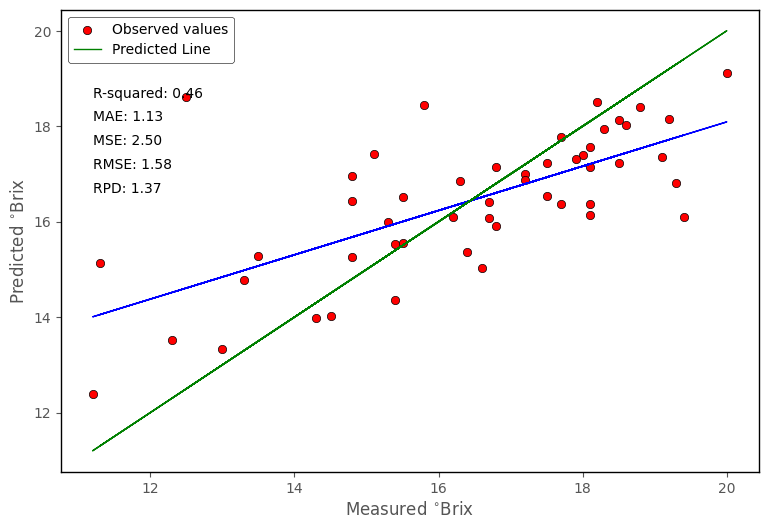

In [194]:
# Regression plot
z = np.polyfit(y, y_pred, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.scatter(y, y_pred, c='red', edgecolors='k', label='Observed values')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1, label = "Predicted Line")
    #plt.title('$R^{2}$ (CV): '+str(r2score_))
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set_facecolor("white")
    plt.xlabel('Measured $^{\circ}$Brix')
    plt.ylabel('Predicted $^{\circ}$Brix')

    plt.text(np.min(y), np.max(y_pred) - 0.5, f"R-squared: {r2score_:.2f}")
    plt.text(np.min(y), np.max(y_pred) - 1, f"MAE: {mae_:.2f}")
    plt.text(np.min(y), np.max(y_pred) - 1.5, f"MSE: {mse_:.2f}")
    plt.text(np.min(y), np.max(y_pred) - 2, f"RMSE: {rmse_:.2f}")
    plt.text(np.min(y), np.max(y_pred) - 2.5, f"RPD: {rpd_:.2f}")
    plt.legend(facecolor='white', edgecolor='black')
    plt.show()

100% completed
Suggested number of components:  1



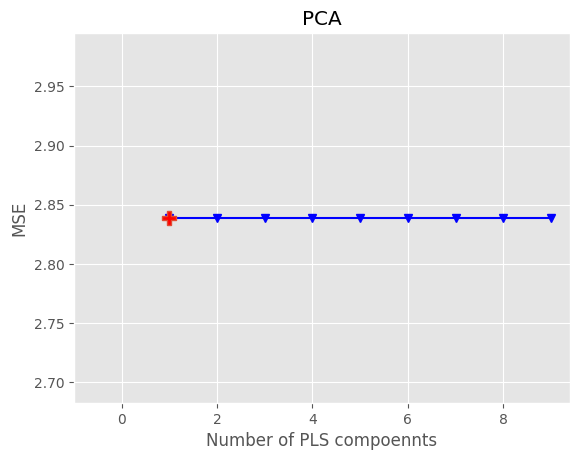

In [195]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sys import stdout

n_comps_ = 10
mse = []
component = np.arange(1, n_comps_)

for i in component:
    # Create linear regression object 
    regr = LinearRegression() 
    # Fit 
    regr.fit(x_comps, y) 
    # Calibration 
    y_c = regr.predict(x_comps)
    y_cv = cross_val_predict(regr, x_comps, y, cv=10)
    mse.append(mean_squared_error(y, y_cv))
    comp = 100*(i+1)/n_comps_
    stdout.write("\r%d%% completed" % comp)
    stdout.flush()
stdout.write("\n")

msemin = np.argmin(mse)
print("Suggested number of components: ", msemin+1)
stdout.write("\n")
plot_components = True
if plot_components is True:
    with plt.style.context(('ggplot')):
        plt.plot(component, np.array(mse), '-v', color = "blue", mfc = 'blue')
        plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
        plt.xlabel('Number of PLS compoennts')
        plt.ylabel('MSE')
        plt.title('PCA')
        plt.xlim(left=-1)
    plt.show()

# Statistical Testing

In [160]:
## Ordinary Least Square - Linear Regression
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
X = sm.add_constant(x_comps[:,:n_comps_new])
ols_model = sm.OLS(y, X).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     7.623
Date:                Mon, 24 Jun 2024   Prob (F-statistic):           3.14e-05
Time:                        16:05:04   Log-Likelihood:                -93.822
No. Observations:                  50   AIC:                             199.6
Df Residuals:                      44   BIC:                             211.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4360      0.238     68.997      0.000      15.956      16.916
x1            -0.0017      0.011     -0.161      0.873      -0.024       0.020
x2             0.0143      0.025      0.562      0.577      -0.037       0.066
x3             0.1095      0.053      2.073      0.044       0.003       0.216
x4            -0.4305      0.085     -5.051      0.000      -0.602      -0.259
x5            -0.4040      0.143     -2.821      0.007      -0.693      -0.115
==============================================================================
Omnibus:                       21.307   Durbin-Watson:                   2.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.113
Skew:                          -1.305   Prob(JB):                     1.44e-08
Kurtosis:                       6.245   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Coefficient of Determination (R²)

In [161]:
print('R2 score:', ols_model.rsquared)
print('It means {} % of our dependent (response) variable can be explained using our independent (predictor) variables'.format(round(ols_model.rsquared*100, 2)))

R2 score: 0.4641508329221844
It means 46.42 % of our dependent (response) variable can be explained using our independent (predictor) variables


## F-test (ANOVA)

In [162]:
print('F-statistic:', ols_model.fvalue)
print('Probability of observing value at least as high as F-statistic:', ols_model.f_pvalue)
if ols_model.f_pvalue<0.05:
    print('Because our f_pvalue is lower than 0.05 we can conclude that our model performs better than other simpler model.')
else:
    print('Because our f_pvalue is higher than 0.05 we can conclude that our model performs worse than other simpler model.')

F-statistic: 7.622531825494225
Probability of observing value at least as high as F-statistic: 3.141244178810273e-05
Because our f_pvalue is lower than 0.05 we can conclude that our model performs better than other simpler model.


## T-test

In [163]:
print(ols_model.pvalues)

[1.73434208e-46 8.73038116e-01 5.76809409e-01 4.40292689e-02
 8.13551958e-06 7.16411291e-03]


# Assumption Testing

In [165]:
# Residual/Error
residual_ = y - y_pred

dataset['brix_pred'] = y_pred
dataset['residual'] = residual_
dataset.head()

,Brix,1100,1102,1104,1106,1108,1110,1112,1114,1116,...,2284,2286,2288,2290,2292,2294,2296,2298,brix_pred,residual
0,15.5,-1.032355,-1.030551,-1.027970,-1.024937,-1.021866,-1.019143,-1.016866,-1.014910,-1.012907,...,0.692376,0.690764,0.688081,0.684294,0.679348,0.673240,0.665922,0.657307,15.559435,-0.059435
1,16.7,-1.139034,-1.137186,-1.134485,-1.131222,-1.127761,-1.124464,-1.121508,-1.118802,-1.115973,...,0.725548,0.721815,0.716767,0.710405,0.702706,0.693710,0.683480,0.671960,16.417065,0.282935
2,18.1,-1.152821,-1.150937,-1.148288,-1.145165,-1.141951,-1.138977,-1.136366,-1.134011,-1.131516,...,0.732669,0.728911,0.723844,0.717415,0.709645,0.700555,0.690147,0.678390,16.365946,1.734054
3,14.8,-1.087215,-1.085455,-1.082867,-1.079797,-1.076568,-1.073632,-1.071087,-1.068877,-1.066654,...,0.756038,0.752903,0.748496,0.742886,0.736085,0.728019,0.718577,0.707702,16.958625,-2.158625
4,15.1,-1.080364,-1.078436,-1.075784,-1.072693,-1.069562,-1.066691,-1.064214,-1.062025,-1.059787,...,0.716860,0.713771,0.709577,0.704232,0.697717,0.689882,0.680748,0.670263,17.425238,-2.325238


## Linearity

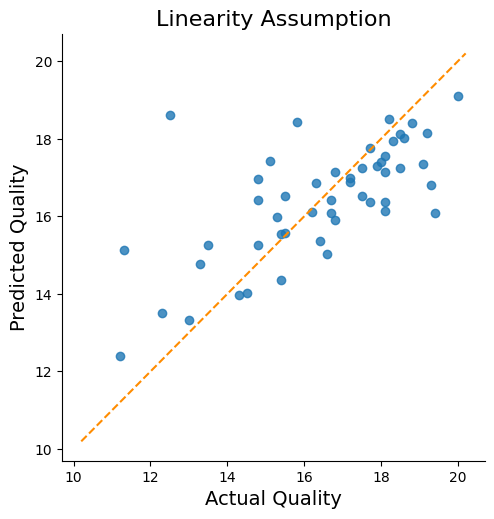

there is linear relationship between our independent and dependent variables.


In [ ]:
# Plotting the observed vs predited values
sns.lmplot(x='Brix', y='brix_pred', data=dataset, fit_reg=False)

# Plotting the diagonal line
line_coords = np.arange(dataset[['Brix', 'brix_pred']].min().min()-1, 
                        dataset[['Brix', 'brix_pred']].max().max()+1)
plt.plot(line_coords, line_coords,  # X and y points
         color='darkorange', linestyle='--')

plt.ylabel('Predicted Quality', fontsize = 14)
plt.xlabel('Actual Quality', fontsize = 14)
plt.title('Linearity Assumption', fontsize = 16)
plt.show()
print("there is linear relationship between our independent and dependent variables.")

## Normality

p-value from the test Anderson-Darling test below 0.05 generally means non-normal: 0.002340180293302539
Residuals are not normally distributed


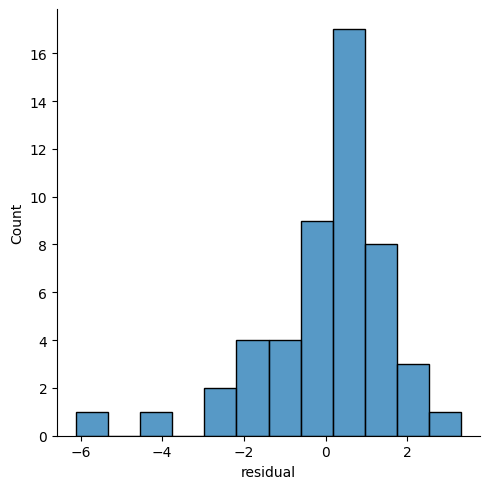

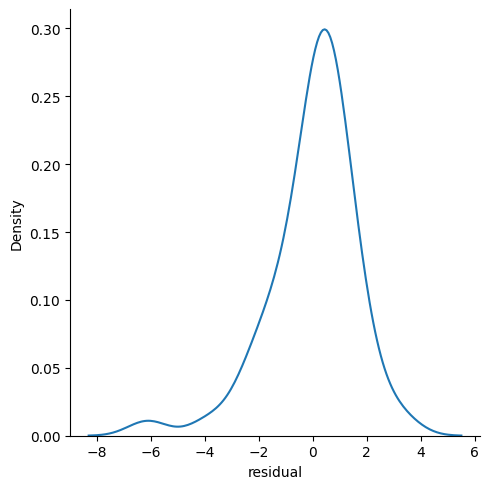

In [ ]:
from statsmodels.stats.diagnostic import normal_ad

# Performing the test on the residuals
p_value = normal_ad(dataset['residual'])[1]
print('p-value from the test Anderson-Darling test below 0.05 generally means non-normal:', p_value)

# Plotting the residuals distribution
sns.displot(dataset['residual'])
sns.displot(dataset['residual'], kind='kde')

# Reporting the normality of the residuals
if p_value < 0.05:
    print('Residuals are not normally distributed')
else: 
    print('Residuals are normally distributed')

## Multicollinearity

Pearson correlation coefficient matrix of each variables:
           PC1       PC2       PC3       PC4       PC5
PC1  1.000000 -0.334837  0.335698  0.605731  0.605525
PC2 -0.334837  1.000000  0.714526  0.094589  0.395016
PC3  0.335698  0.714526  1.000000  0.711674  0.917911
PC4  0.605731  0.094589  0.711674  1.000000  0.864493
PC5  0.605525  0.395016  0.917911  0.864493  1.000000


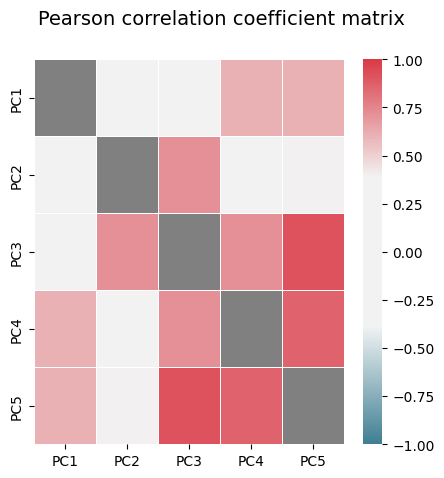

In [166]:
corr = df_xcomps[['PC1','PC2', 'PC3', 'PC4', 'PC5']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

# Generate a mask for the diagonal cell
mask = np.zeros_like(corr, dtype=bool)
np.fill_diagonal(mask, val=True)

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
cmap.set_bad('grey')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Pearson correlation coefficient matrix', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=10)
# fig.tight_layout()

## Autocorrelation

In [167]:
from statsmodels.stats.stattools import durbin_watson

durbinWatson = durbin_watson(dataset['residual'])

print('Durbin-Watson:', durbinWatson)
if durbinWatson < 1.5:
    print('Signs of positive autocorrelation', '\n')
    print('Assumption not satisfied')
elif durbinWatson > 2.5:
    print('Signs of negative autocorrelation', '\n')
    print('Assumption not satisfied')
else:
    print('Little to no autocorrelation', '\n')
    print('Assumption satisfied')

Durbin-Watson: 2.313428632284912
Little to no autocorrelation 

Assumption satisfied


## Homoscedasticity

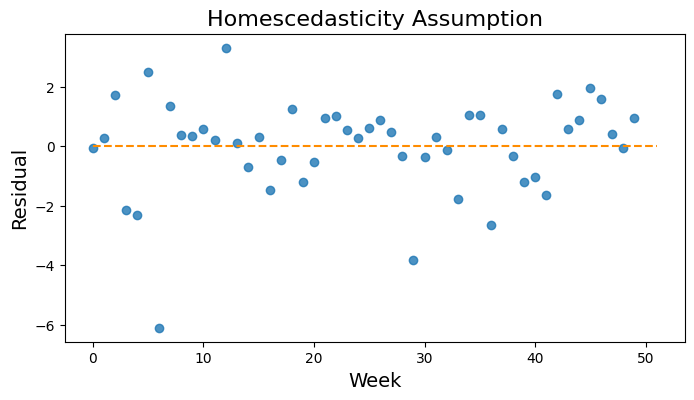

In [169]:
plt.subplots(figsize=(8, 4))
plt.scatter(x=dataset.index, y=dataset.residual, alpha=0.8)
plt.plot(np.repeat(0, len(dataset.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Week', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show()